<div style="background-color: #008B8B; color: white; padding: 20px; border-radius: 5px; font-size: 24px;">
  JIL-TestDataScience-2 - Problema de series temporales
</div>


# **1. Objetivo**

---

El objetivo de este análisis es desarrollar un modelo predictivo capaz de estimar el comportamiento futuro de una variable objetivo dentro de una serie temporal multivariante no financiera y sin estacionalidad.

Se busca predecir los próximos 100 periodos de tiempo sin disponer de los valores futuros de las variables regresoras. Para ello:

- Seleccionaremos un dataset abierto adecuado.
- Comprobaremos que la serie no presenta estacionalidad (algo difícil) o la eliminaremos.
- Entrenaremos los modelos de predicción que consideremos más adecuados.
- Evaluaremos el rendimiento de los modelos mediante la comparativa de métricas adecuadas y sus visualizaciones.

# **2. Paquetes**

---



In [31]:
# Conexión a google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/JIL-TestDataScience-2

Mounted at /content/drive
/content/drive/MyDrive/JIL-TestDataScience-2


In [1]:
# Datos
from ucimlrepo import fetch_ucirepo

# Tratamiento básico y visualización
import os
import wget
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import math

# Test estadísticos y sobre propiedades de la serie
from sktime.param_est.stationarity import StationarityADF
from statsmodels.tsa.stattools import grangercausalitytests
from sktime.transformations.series.detrend import Detrender
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts.utils.statistics import plot_acf, check_seasonality, remove_seasonality, plot_ccf
from darts.utils.utils import SeasonalityMode
from darts.timeseries import TimeSeries
from statsmodels.tsa.stattools import adfuller

# Vector AR
from sktime.forecasting.var import VAR

# Preprocesado y métricas
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.transformations.series.difference import Differencer

# XGBoost
from xgboost import XGBRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from tensorflow.keras.losses import MeanSquaredError

# Otros
import joblib
import warnings
warnings.filterwarnings('ignore')

# **3. Lectura de datos**

---


En este análisis utilizaremos el dataset Power Consumption of Tetouan City, que contiene datos multivariantes de consumo eléctrico en tres zonas de la ciudad de Tétouan, junto a variables meteorológicas (temperatura, humedad, velocidad del viento, flujos difusos) en intervalos de diez minutos (https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city)


En la siguiente tabla hacemos una descripción de cada una de estas variables:


| **Nombre de la Variable**        | **Tipo**             | **Tipo de Dato** | **Descripción**                                                    | **Valores Nulos** |
|----------------------------------|----------------------|------------------|--------------------------------------------------------------------|-------------------|
| DateTime                         | Característica       | Fecha / Tiempo   | Registro de tiempo en intervalos de diez minutos                   | No                |
| Temperature                      | Característica       | Continua         | Temperatura del aire en la ciudad de Tetuán                        | No                |
| Humidity                         | Característica       | Continua         | Humedad del aire en la ciudad de Tetuán                            | No                |
| Wind Speed                       | Característica       | Continua         | Velocidad del viento en la ciudad de Tetuán                        | No                |
| General Diffuse Flows            | Característica       | Continua         | Flujos difusos generales registrados                               | No                |
| Diffuse Flows                    | Característica       | Continua         | Flujos difusos registrados                                          | No                |
| Zone 1 Power Consumption         | Variable Objetivo    | Continua         | Consumo eléctrico de la Zona 1 de la ciudad de Tetuán              | No                |
| Zone 2 Power Consumption         | Variable Objetivo    | Continua         | Consumo eléctrico de la Zona 2 de la ciudad de Tetuán              | No                |
| Zone 3 Power Consumption         | Variable Objetivo    | Continua         | Consumo eléctrico de la Zona 3 de la ciudad de Tetuán              | No                |


El objetivo concreto que nos hemos propuesto consiste en desarrollar un modelo capaz de predecir los próximos 100 periodos del consumo eléctrico de la ciudad, consideando el consumo total como la suma de los consumos de las tres zonas delimitadas que conocemos.

In [2]:
power_consumption_of_tetouan_city = fetch_ucirepo(id=849)

X = power_consumption_of_tetouan_city.data.features
y = power_consumption_of_tetouan_city.data.targets

df = pd.concat([X,y], axis = 1)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
target = 'Total Power Consumption'
regresores = ['Temperature', 'Humidity', 'Wind Speed','general diffuse flows',	'diffuse flows']

df[target] = df[['Zone 1 Power Consumption',
                 'Zone 2  Power Consumption',
                 'Zone 3  Power Consumption']].sum(axis=1)

df = df.drop(columns=['Zone 1 Power Consumption',
                      'Zone 2  Power Consumption',
                      'Zone 3  Power Consumption'
                      ])

df = df.resample('H').mean()
df.shape

(8736, 6)

Antes de pasar a comprobar las propeidades de la serie, debemos mencionar que el conjunto de datos abarca el periodo comprendido entre el 1 de enero de 2017 a las 00:00:00 y el 30 de diciembre de 2017 a las 23:00:00, conteniendo un total de 8736 registros y 6 variables.

# **4. Estacionalidad de la serie**

---


Las series temporales de consumo eléctrico suelen presentar comportamientos estacionales debido a los patrones repetitivos de la demanda energética a lo largo del tiempo. En particular, cuando los datos se registran con una frecuencia horaria, es común observar estacionalidad diaria, es decir, ciclos que se repiten cada 24 horas, así como posibles estacionalidades en múltiplos de 24 horas (por ejemplo, semanales).

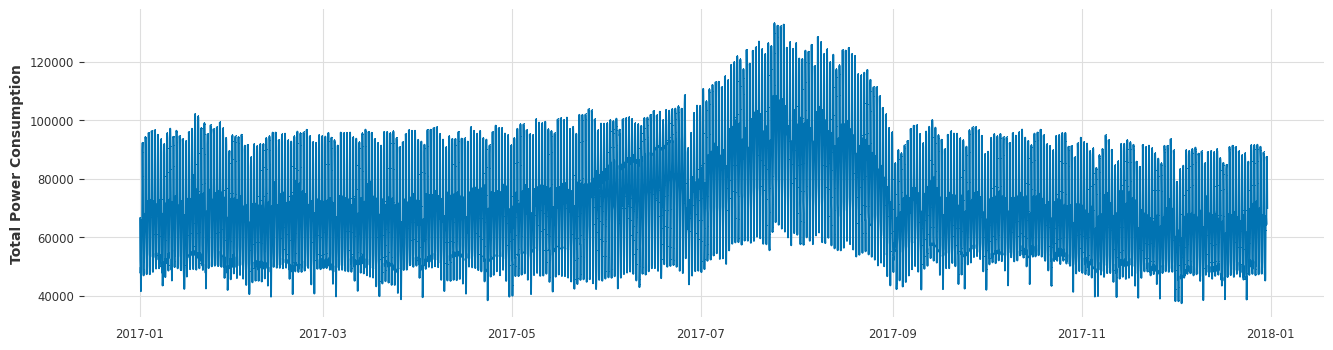

In [3]:
plot_series(df[target], markers=",")
plt.show()

En esta primera visualización no se aprecia claramente ningún patrón definido, ya que los datos se encuentran muy densos y próximos entre sí, lo que dificulta la identificación visual de posibles ciclos o tendencias. Por este motivo, se procederá a analizar la función de autocorrelación (ACF), que permitirá evaluar de forma más precisa la existencia de dependencias temporales o estacionalidad en la serie.

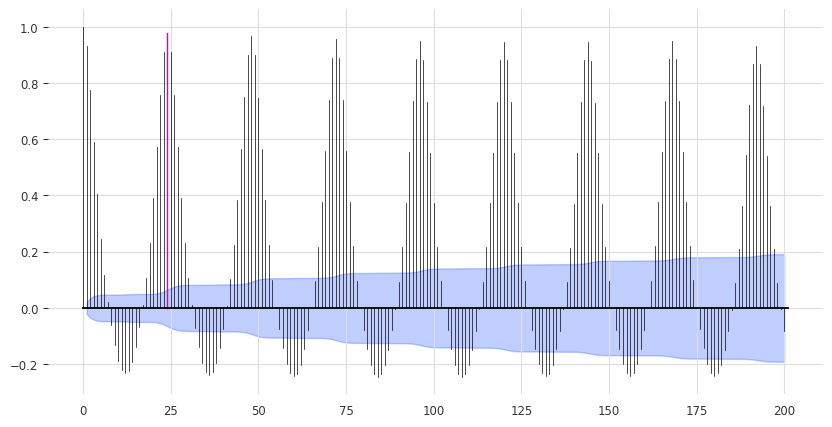

In [4]:
series = TimeSeries.from_series(df[target])
plot_acf(series[target], max_lag=200, m=24)

Efectivamente, en la función de autocorrelación (ACF) se observa un patrón claro con periodicidad de 24 horas, lo que indica la presencia de estacionalidad diaria. Para confirmar este comportamiento, utilizaremos la función check_seasonality() del paquete Darts.

In [5]:
is_seasonal, period = check_seasonality(series, alpha=0.05, max_lag=200)
if is_seasonal:
    print('There is seasonality of order {}.'.format(period))

There is seasonality of order 24.


Una vez identificado el patrón estacional de 24 horas, procederemos a eliminarlo utilizando la función remove_seasonality() del mismo paquete, con el objetivo de obtener una serie no estacional que facilite el modelado y la predicción.

<Axes: xlabel='time'>

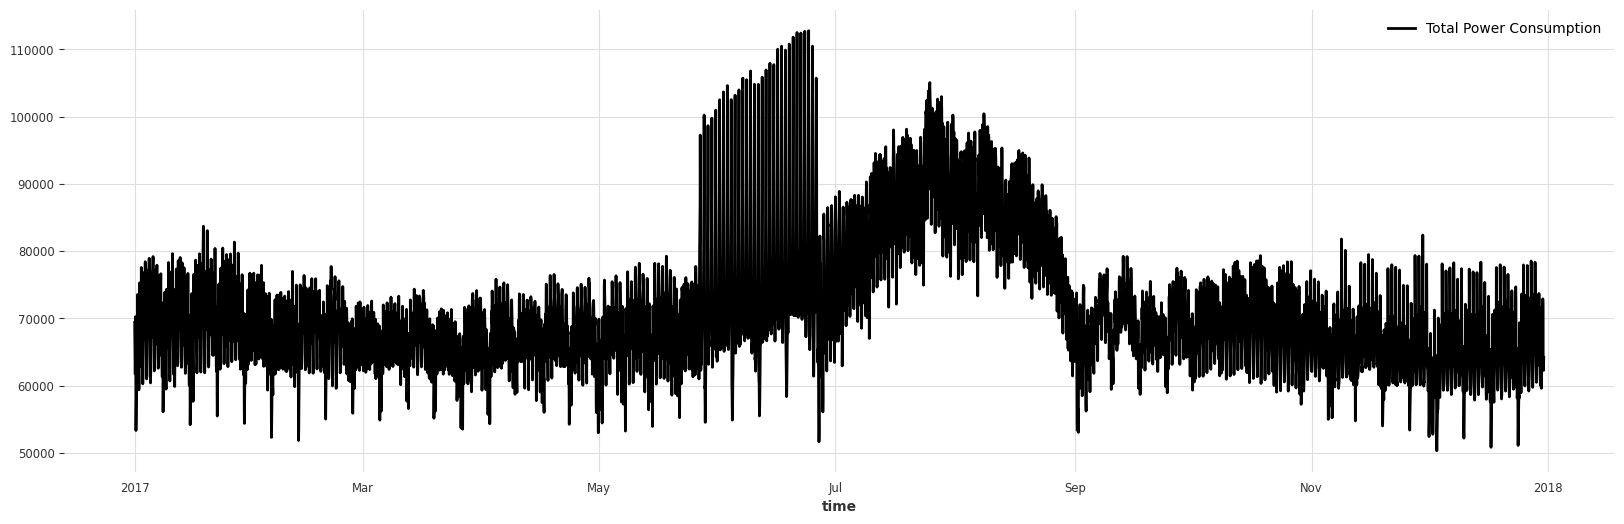

In [6]:
non_seasonal = remove_seasonality(series[target], model=SeasonalityMode.MULTIPLICATIVE)
plt.figure(figsize=(20, 6))
non_seasonal.plot()

Unimos todos nuestros regresores con la variable objetivo nuevamente para poder usarlos en el apartado de modelización.

In [7]:
df_aux = non_seasonal[target].to_dataframe()
df_aux.columns = [target]
df = pd.concat([df.drop(target, axis = 1), df_aux] , axis = 1)

# **5. Estacionariedad**

---


Aunque no se ha solicitado explícitamente, es conveniente estudiar la estacionariedad de la serie objetivo y de las variables regresoras, ya que esta es una condición necesaria para entrenar correctamente un modelo VAR (Vector Autoregressive). Verificar que las series sean estacionarias permite garantizar que las relaciones temporales entre variables sean estables en el tiempo y que el modelo pueda generar predicciones confiables.

In [8]:
from statsmodels.tsa.stattools import adfuller

for key in df.columns:
    serie = df[key].dropna()
    result = adfuller(serie)
    p_value = result[1]
    print(f"{key}: p-value = {p_value:.5f} -> {'Estacionaria ✅' if p_value < 0.1 else 'No estacionaria ❌'}")

Temperature: p-value = 0.02797 -> Estacionaria ✅
Humidity: p-value = 0.00000 -> Estacionaria ✅
Wind Speed: p-value = 0.00000 -> Estacionaria ✅
general diffuse flows: p-value = 0.00000 -> Estacionaria ✅
diffuse flows: p-value = 0.00000 -> Estacionaria ✅
Total Power Consumption: p-value = 0.06710 -> Estacionaria ✅


Para comprobar la estacionariedad de las series, se ha aplicado el test de Dickey-Fuller aumentado (ADF) a la serie objetivo y a las variables regresoras. Todos los tests han confirmado que las series son estacionarias, cumpliendo el criterio con un nivel de significación del 90%.

# **6. Correlación entre regresores**

---


Del estudio de la matriz de correlación podemos sacar que, salvo la variable temperatura, el resto de las regresoras presentan una baja correlación con la variable de consumo eléctrico total. Por lo que, salvo que la serie objetivo presente un fuerte componente estacional, será difícil obtener resultados precisos en la predicción debido a la baja influencia que la mayoría de las variables regresoras ejercen sobre el target. Es decir, el modelo dependerá principalmente de la información histórica de la propia serie, siendo la contribución de las regresoras limitada.

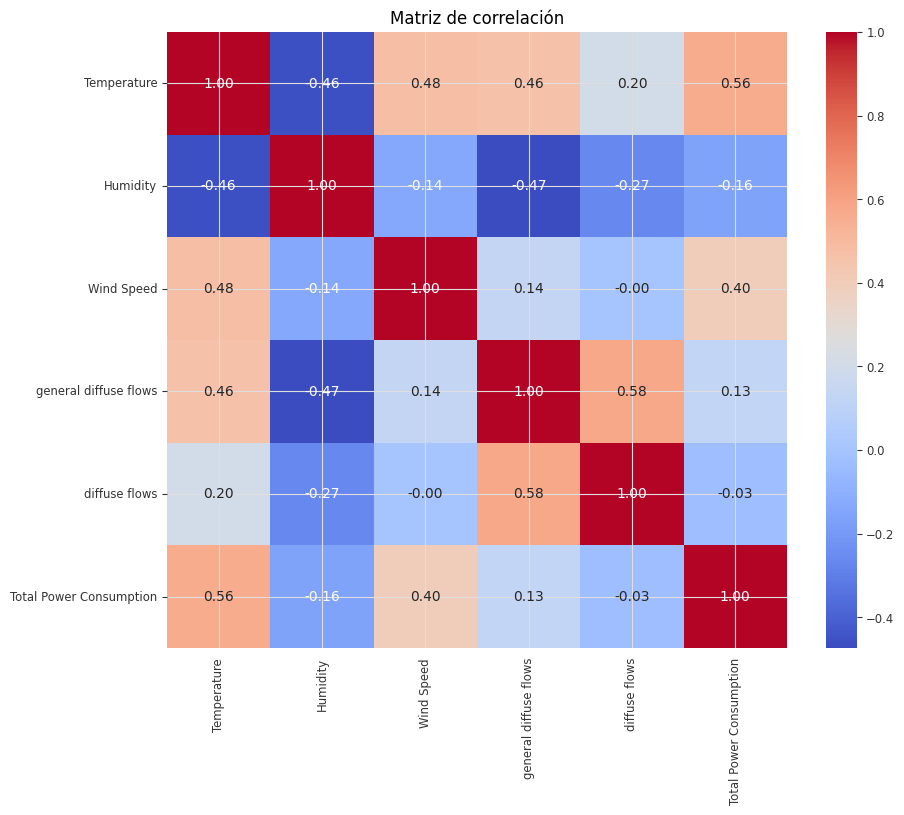

In [9]:
corr = df.corr()
corr.style.background_gradient(cmap=ListedColormap(["#e5f6ff","#82cfff","#3ddbd9","#be95ff","#ff7eb6"]))
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

NOTA: Una forma más rigurosa de evaluar si las variables tienen capacidad predictiva sobre el target es aplicar el test de causalidad de Granger, que permite determinar si una serie temporal ayuda a pronosticar otra considerando relaciones temporales y rezagos. Sin embargo, en este caso no se realizará este test, ya que estamos preparando una muestra genérica que nos permita entrenar varios modelos, independientemente de si las relaciones entre variables son lineales o no.


# **7. División en train, validación y test** **texto en negrita**

---


A continuación, se procederá a dividir el conjunto de datos en tres subconjuntos: train, validación y test. Se reservarán 500 registros para el conjunto de validación, con el objetivo de emplearlos más adelante en tareas de backtesting de algunos modelos, evaluando su capacidad de predicción sobre datos no vistos durante el entrenamiento.

In [10]:
end_validation = len(df)-100
end_train = len(df)-100-500

df_train = df.iloc[:end_train, :].copy()
df_val = df.iloc[end_train:end_validation, :].copy()
df_test = df.iloc[end_validation:, :].copy()

print(
    f"Dates train      : {df_train.index.min()} --- "
    f"{df_train.index.max()}  (n={len(df_train)})"
)
print(
    f"Dates validation : {df_val.index.min()} --- "
    f"{df_val.index.max()}  (n={len(df_val)})"
)
print(
    f"Dates test       : {df_test.index.min()} --- "
    f"{df_test.index.max()}  (n={len(df_test)})"
)

Dates train      : 2017-01-01 00:00:00 --- 2017-12-05 23:00:00  (n=8136)
Dates validation : 2017-12-06 00:00:00 --- 2017-12-26 19:00:00  (n=500)
Dates test       : 2017-12-26 20:00:00 --- 2017-12-30 23:00:00  (n=100)


En la siguiente imagen podemos ver la distribución final de nuestra muestra:

<Axes: >

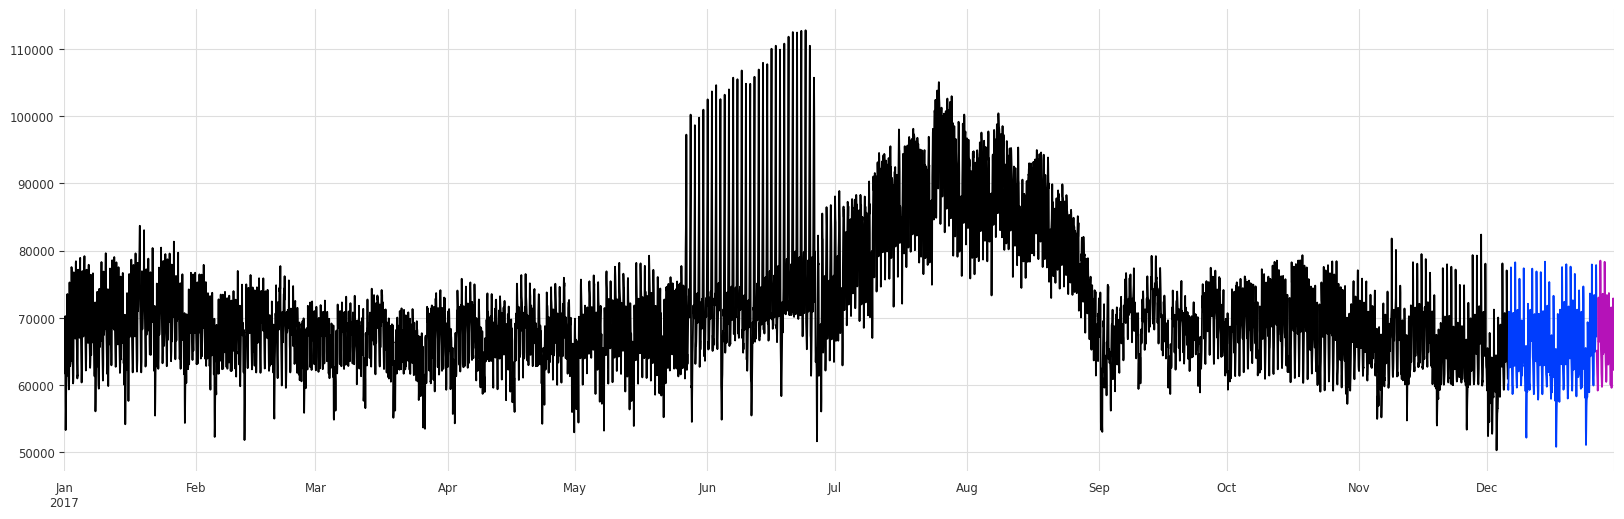

In [11]:
plt.figure(figsize=(20, 6))
df_train[target].plot(label='Train')
df_val[target].plot(label='Val')
df_test[target].plot(label='Test')

# **8. Vector Autoregressive model (VAR)**

---


El primer modelo que se va a evaluar es un modelo VAR (Vector Autoregressive), que permite capturar las relaciones lineales entre series temporales multivariantes. En este caso, no se utilizarán conjuntos de validación ni backtesting, sino que se realizará la división clásica train/test, dado que el objetivo inicial es analizar el comportamiento básico del modelo y su capacidad de predicción inmediata sobre datos no vistos, sin ajustes de hiperparámetros ni optimización adicional. Para implementar este modelo se empleará el paquete sktime, que proporciona herramientas eficientes para trabajar con series temporales multivariantes y modelos autoregresivos.

Este primer modelo se tomará como un modelo "baseline", es decir, una referencia inicial frente a la cual se podrán comparar los resultados de modelos más complejos o avanzados.

In [12]:
future_context = 100
data = pd.concat([df_train, df_val],axis = 0)
forecaster_var = VAR(ic='bic')
forecaster_var.fit(data, fh= np.arange(1,future_context + 1))
y_pred = forecaster_var.predict()

Una vez realizadas las predicciones, se observa que la estacionalidad de la serie no se ha eliminado por completo, a pesar de haber aplicado la función remove_seasonality() de Darts. Una posible estrategia para eliminar la estacionalidad remanente podría haber sido diferenciar la serie temporal. Sin embargo, según las pruebas realizadas, la serie parece presentar múltiples componentes estacionales, y al aplicar la diferenciación se introduce más ruido que señal, lo que dificulta la construcción de un modelo preciso y robusto.

Por ello, y debido a restricciones de tiempo, no se realizará un ajuste adicional y continuaremos la modelización aceptando la presencia de patrones estacionales débiles.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total Power Consumption'>)

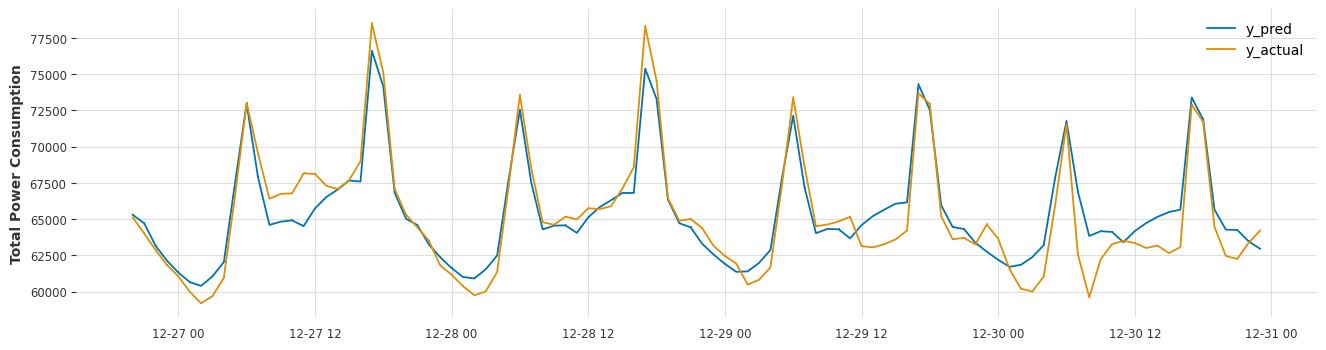

In [13]:
plot_series(y_pred[target], df_test[target], labels=["y_pred", "y_actual"], markers=[',',','])

Ahora bien, echando un vistazo a la gráfica se observa que el modelo ha capturado muy bien el comportamiento de la serie, reproduciendo con precisión sus fluctuaciones. Esto se refleja claramente en las predicciones obtenidas, que muestran un ajuste cercano a los valores reales, logrando un MAPE de tan solo 1,71%, lo que indica un error medio porcentual muy bajo y un desempeño satisfactorio para este modelo baseline.

In [14]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

metrics = {}
mae =  round(mean_absolute_error(df_test[target], y_pred[target]),2)
rmse = round(math.sqrt(mean_squared_error(df_test[target], y_pred[target])),2)
mape =  round(mean_absolute_percentage_error(df_test[target], y_pred[target]),6)*100
metrics[target] = { 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
metrics_df = pd.DataFrame(metrics).T
metrics_df.index = ['VAR']
metrics_df

,MAE,RMSE,MAPE
VAR,1106.46,1425.69,1.7105


# 9. XGBoost autorregresivo con predicción directa
---




El siguiente enfoque consiste en un modelo autorregresivo multiserie basado en XGBoost, en el que cada valor futuro de la serie se predice directamente a partir de los lags pasados. En este caso, se han utilizado hasta 100 lags para capturar la dinámica reciente de la serie, aprovechando la capacidad de XGBoost para modelar relaciones no lineales entre los valores históricos y el target. La selección de hiperparámetros se ha realizado mediante un GridSearch, evaluando distintos valores de n_estimators, max_depth y learning_rate, así como diferentes longitudes de lags (20, 50, 100).

In [15]:
forecaster = ForecasterAutoregMultiSeries(
    regressor = XGBRegressor(
        random_state=42,
        enable_categorical=True
    ),
    lags = 24)

lags_grid = [20, 50, 100]

param_grid = {
    'n_estimators': [10, 20, 30, 50, 100],
    'max_depth': [3, 5],
    'learning_rate':[0.01,0.1,0.3]
}

levels = target
results = grid_search_forecaster_multiseries(
              forecaster         = forecaster,
              series             = df,
              exog               = None,
              levels             = levels,
              lags_grid          = lags_grid,
              param_grid         = param_grid,
              steps              = 100,
              metric             = 'mean_absolute_error',
              aggregate_metric   = 'weighted_average',
              initial_train_size = len(df.iloc[:end_train, :]),
              refit              = False,
              fixed_train_size   = False,
              return_best        = False,
              n_jobs             = 'auto',
              verbose            = False,
              show_progress      = True
          )

results.head()

90 models compared for 1 level(s). Number of iterations: 90.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/30 [00:00<?, ?it/s]

,levels,lags,lags_label,params,mean_absolute_error,learning_rate,max_depth,n_estimators
0,[Total Power Consumption],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1821.690987,0.1,5.0,100.0
1,[Total Power Consumption],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1857.488769,0.1,5.0,100.0
2,[Total Power Consumption],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",1903.981536,0.3,5.0,50.0
3,[Total Power Consumption],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",1937.233934,0.3,5.0,50.0
4,[Total Power Consumption],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",1990.105087,0.3,5.0,20.0


El modelo se ha evaluado mediante backtesting multiserie, prediciendo los próximos 100 pasos a partir del conjunto de validación.

In [16]:
metrics_xgboost, predictions_xgboost = backtesting_forecaster_multiseries(
                                 forecaster         = forecaster,
                                 series             = df,
                                 levels             = levels,
                                 initial_train_size = len(df.iloc[:end_validation, :]),
                                 fixed_train_size   = True,
                                 steps              = 100,
                                 metric             =  [mean_absolute_error, mean_squared_error, 'mean_absolute_percentage_error',],
                                 refit              = True,
                                 verbose            = False)

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
metrics_xgboost = metrics_xgboost.drop('levels', axis = 1)
metrics_xgboost.columns = ['MAE', 'RMSE', 'MAPE']
metrics_xgboost['RMSE'] = np.sqrt(metrics_xgboost['RMSE'])
metrics_xgboost['MAPE'] = metrics_xgboost['MAPE'] * 100
metrics_xgboost.index = ['XGBoost'] * len(metrics_xgboost)

Los resultados obtenidos muestran que el modelo logra ajustar bien la serie objetivo, aunque no consigue superar el desempeño de nuestro modelo base VAR. Esto sugiere que, en este caso particular, la información contenida en las regresoras y en los lags adicionales no aporta mejoras significativas (algo que ya habíamos comentado), y que la dinámica principal de la serie objetivo ya está siendo capturada de manera eficiente por el modelo lineal baseline.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total Power Consumption'>)

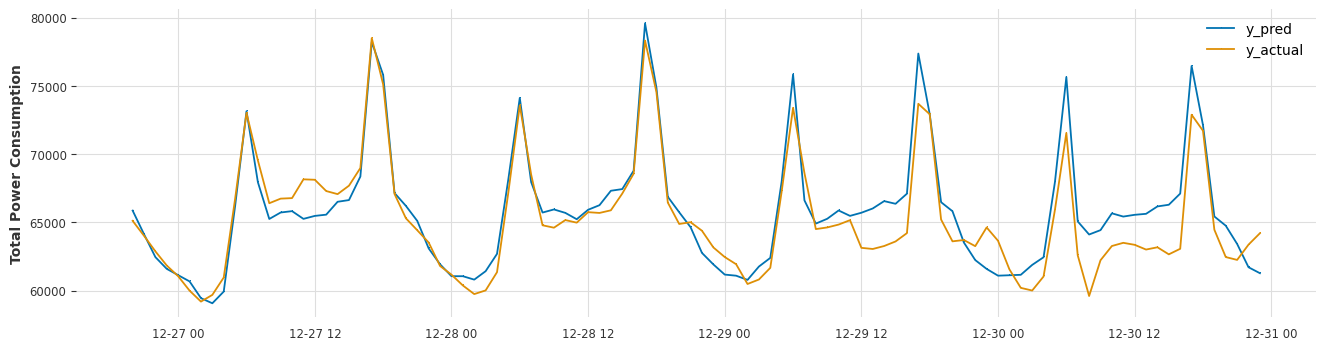

In [18]:
plot_series(predictions_xgboost[-100:][target],
            df_test[target], labels=["y_pred", "y_actual"], markers=[',',','])

In [19]:
metrics_xgboost

,MAE,RMSE,MAPE
XGBoost,1338.336931,1722.401419,2.063663


# 10. LSTM autorregresivo
---

Como siguiente enfoque, se ha decidido entrenar un modelo LSTM (Long Short-Term Memory) para capturar relaciones temporales más complejas entre la serie objetivo y las variables regresoras. En este caso, se han considerado 32 lags y se busca predecir 100 pasos hacia el futuro, siguiendo un esquema de predicción directa.

In [20]:
series = regresores
levels = target
lags = 32
steps = 100
model = create_and_compile_model(
    series=df_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError())
model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,644 (318.92 KB)

 Trainable params: 81,644 (318.92 KB)

 Non-trainable params: 0 (0.00 B)

Antes de entrenar la red, los datos se han sometido a un escalado mediante MinMaxScaler, garantizando que los valores de entrada se encuentren en un rango adecuado para el entrenamiento de la LSTM. Además, se han transformado al formato requerido por la red, donde cada muestra contiene los lags de todas las variables como entradas y los pasos futuros del target como salida. La arquitectura propuesta consta de dos capas recurrentes LSTM con 100 y 50 unidades respectivamente, seguidas de dos capas densas con 64 y 32 unidades, optimizadas con el Adam y utilizando Mean Squared Error como función de pérdida.

In [21]:
forecaster = ForecasterRnn(
    regressor=model,
    levels=target,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 50,
        "batch_size": 128,
        "series_val": df_val,
    },
)

In [22]:
forecaster.fit(df_train)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0976 - val_loss: 0.0407
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0111 - val_loss: 0.0320
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0097 - val_loss: 0.0333
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0093 - val_loss: 0.0318
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0093 - val_loss: 0.0328
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0091 - val_loss: 0.0320
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0090 - val_loss: 0.0337
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0089 - val_loss: 0.0349
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0088 - val_loss: 0.0335
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0087 - val_loss: 0.0368
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0085 - val_loss: 0.0325
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - l

El modelo se ha entrenado utilizando el conjunto de train y validado con un subconjunto de 500 registros, empleando un tamaño de batch de 128 y 50 épocas. Posteriormente, se ha evaluado mediante backtesting multiserie, calculando métricas de desempeño como MAE, MSE y MAPE. Este enfoque permite capturar patrones no lineales y dependencias temporales complejas que los modelos lineales o basados en árboles no pueden representar.

In [23]:
metrics_lstm, predictions_lstm = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=df,
    levels=forecaster.levels,
    initial_train_size=len(df.iloc[:end_validation, :]),
    metric= [mean_absolute_error, mean_squared_error, 'mean_absolute_percentage_error'],
    verbose=False,
    refit=True)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 0.0034 - val_loss: 0.0353
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0034 - val_loss: 0.0355
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0033 - val_loss: 0.0352
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0033 - val_loss: 0.0353
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0032 - val_loss: 0.0352
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0032 - val_loss: 0.0340
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0031 - val_loss: 0.0345
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0031 - val_loss: 0.0343
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0031 - val_loss: 0.0338
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0030 - val_loss: 0.0338
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0031 - val_loss: 0.0346
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - l

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
metrics_lstm = metrics_lstm.drop('levels', axis = 1)
metrics_lstm.columns = ['MAE', 'RMSE', 'MAPE']
metrics_lstm['RMSE'] = np.sqrt(metrics_lstm['RMSE'])
metrics_lstm['MAPE'] = metrics_lstm['MAPE'] * 100
metrics_lstm.index = ['LSTM'] * len(metrics_lstm)


Los resultados muestran que el modelo LSTM captura bastante bien el comportamiento de la serie pero no lo hace tan bien como el VAR o el XGBoost autorregresivo.

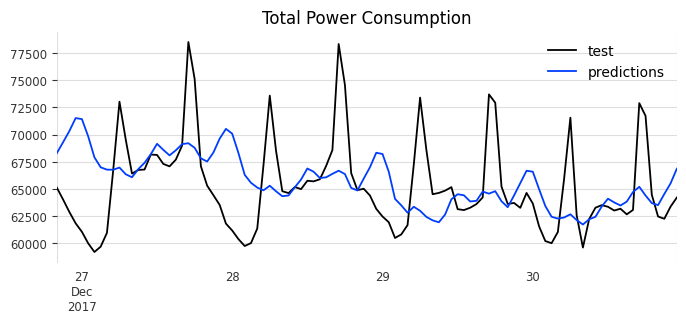

In [25]:
fig, ax = plt.subplots(figsize=(8, 3))
df_test[target].plot(ax=ax, label="test")
predictions_lstm[-100:][target].plot(ax=ax, label="predictions")
ax.set_title(target)
ax.legend();

In [26]:
metrics_lstm

,MAE,RMSE,MAPE
LSTM,3361.834961,4614.127386,5.111292


# 11. Conclusiones
---


En definitiva, considero que el conjunto de datos escogido no ha sido el adecuado, ya que presentaba múltiples estacionalidades difíciles de eliminar, a pesar de haber probado varias estrategias fuera de este Notebook.

Se decidió continuar con la modelización aunque la serie siguiese siendo estacional, con el objetivo de entregar resultados. Aunque no estoy conforme con ello al no poder ceñirme al enunciado del ejercicio solicitado.

En relación a los resultados, vemos que el modelo VAR, el más sencillo, ha sido capaz de ajustarse mejor a los datos. ¿Podría deberse a sobreajuste? Es posible. Idealmente, estas pruebas deberían haberse completado con un análisis de residuos de cada modelo, pero por limitaciones de tiempo no ha sido posible.

In [27]:
pd.concat([metrics_df, metrics_xgboost, metrics_lstm])

,MAE,RMSE,MAPE
VAR,1106.460000,1425.690000,1.710500
XGBoost,1338.336931,1722.401419,2.063663
LSTM,3361.834961,4614.127386,5.111292


El siguiente paso será guardar el modelo VAR y productivizarlo, simulando un escenario real de predicción.

In [32]:
joblib.dump(forecaster_var, "/content/drive/MyDrive/JIL-TestDataScience-2/data/raw/var_model_20251026.pkl")

['/content/drive/MyDrive/JIL-TestDataScience-2/data/raw/var_model_20251026.pkl']